In [1]:
from functions import map_scatter, glasbey
from matplotlib.ticker import LogLocator, ScalarFormatter, NullFormatter
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind, ttest_rel
from google.cloud import storage
from scipy import stats
from scipy.spatial import Delaunay
from matplotlib.collections import PatchCollection
from sklearn.preprocessing import QuantileTransformer
from matplotlib.patches import Polygon
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
from anndata import AnnData
import pandas as pd
import numpy as np
import seaborn as sns
import colorcet as cc
import scanpy as sc
# import nfinder
import copy
import os

In [2]:
# read in data
data_path = "gs://mayo-nguyen-transplant/nduarte-csv/data.csv"
df = pd.read_csv(data_path)

In [3]:
df.columns

Index(['Image', 'Object ID', 'Classification', 'Parent', 'Centroid X µm',
       'Centroid Y µm', 'DAPI', 'CD44', 'HLA-DR', 'CD4', 'IFNG', 'Ki67',
       'CD107a', 'CD45', 'CD20', 'CD40', 'CD8', 'Pan-Cytokeratin', 'CD68',
       'HLA-A', 'CD79a', 'CD45RO', 'CD21', 'CD11c', 'HLA-E', 'IDO1', 'CD14',
       'CD56', 'VISTA', 'FOXP3', 'Granzyme B', 'PCNA', 'T-bet/TBX21', 'PD-L1',
       'TOX', 'PD-1', 'CD38', 'ICOS', 'CD39', 'LAG3', 'TCF-1', 'CD3e', 'Slide',
       'UMAP1', 'UMAP2', 'PC1_1', 'PC2_1', 'PC3_1', 'PC4_1', 'PC5_1', 'PC6_1',
       'PC7_1', 'PC8_1', 'PC9_1', 'PC10_1', 'PC1_hcorr', 'PC2_hcorr',
       'PC3_hcorr', 'PC4_hcorr', 'PC5_hcorr', 'PC6_hcorr', 'PC7_hcorr',
       'PC8_hcorr', 'PC9_hcorr', 'PC10_hcorr', 'UMAP1_hcorr', 'UMAP2_hcorr',
       'Leiden', 'Level 1', 'Level 2', 'Level 3', 'Level 4', 'Phenotype',
       'Timepoint'],
      dtype='object')

In [4]:
metadata = ['Image', 'Object ID', 'Classification', 'Parent', 'Centroid X µm', 'Centroid Y µm', 'UMAP1_hcorr', 'UMAP2_hcorr', 'PC1_hcorr', 'PC2_hcorr', 'PC3_hcorr', 'PC4_hcorr', 'PC5_hcorr', 'PC6_hcorr', 'PC7_hcorr', 'PC8_hcorr', 'PC9_hcorr', 'PC10_hcorr', 'Leiden', 'Level 1', 'Level 2', 'Level 3',
       'Level 4', 'Phenotype', 'Timepoint']
markers = ['DAPI', 'CD44', 'HLA-DR', 'CD4', 'IFNG', 'Ki67', 'CD107a', 'CD45', 'CD20', 'CD40', 'CD8', 'Pan-Cytokeratin', 'CD68', 'HLA-A', 'CD79a', 'CD45RO', 'CD21', 'CD11c', 'HLA-E', 'IDO1', 'CD14', 'CD56', 'VISTA', 'FOXP3', 'Granzyme B', 'PCNA', 'T-bet/TBX21', 'PD-L1', 'TOX', 'PD-1', 'CD38', 'ICOS', 'CD39', 'LAG3', 'TCF-1', 'CD3e']

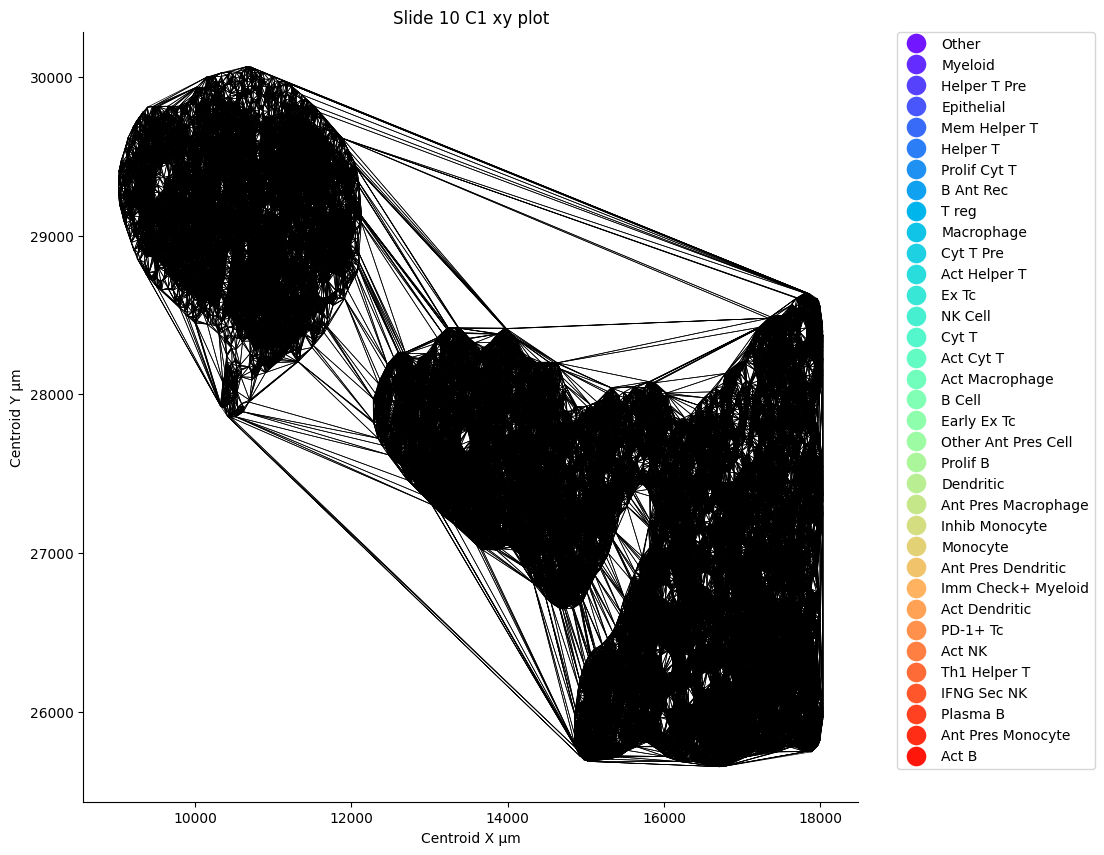

KeyboardInterrupt: 

In [5]:
for slide, group in df.groupby('Parent'):
    points = group[['Centroid X µm', 'Centroid Y µm']].to_numpy()
    tri = Delaunay(points)

    f, ax = plt.subplots(figsize=(10, 10))

    sns.scatterplot(
        x="Centroid X µm", 
        y="Centroid Y µm",
        hue="Phenotype",
        legend="full",
        palette="rainbow",
        data=group,
        ax=ax,
        s=0.5
    ).set(title=f'{slide} xy plot')

    # plot Delaunay triangulation edges
    for simplex in tri.simplices:
        simplex_points = points[simplex]
        ax.plot(
            np.append(simplex_points[:, 0], simplex_points[0, 0]),
            np.append(simplex_points[:, 1], simplex_points[0, 1]),
            'k-', lw=0.5
        )

    sns.despine()
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, markerscale=20, borderaxespad=0.)
    plt.show()

In [5]:
def plot_filtered_triangulation(ax, points, filtered_edges, title):
    """ Plot the Delaunay triangulation with filtered edges (2D array) """
    for edge in filtered_edges:
        x_values = [points[edge[0]][0], points[edge[1]][0]]
        y_values = [points[edge[0]][1], points[edge[1]][1]]
        ax.plot(x_values, y_values, 'r-', lw=1)
    ax.scatter(points[:, 0], points[:, 1], c='blue', s=20)
    ax.set_title(title)

def plot_zoomed_triangulation(ax, points, filtered_edges, title, zoom_factor=0.01):
    """
    Plot a zoomed-in section of the Delaunay triangulation with filtered edges (2D array).

    Parameters:
    ax: matplotlib axis object to plot on
    points: numpy array of shape (n, 2), representing the coordinates of points
    filtered_edges: list of edges to plot, where each edge is a tuple of two point indices
    title: title of the plot
    zoom_factor: float, fraction of the graph to zoom in on, centered at the middle
    """
    # zoom in on center of the graph
    min_x, min_y = points.min(axis=0)
    max_x, max_y = points.max(axis=0)
    center_x = (min_x + max_x) / 2
    center_y = (min_y + max_y) / 2

    width = (max_x - min_x) * zoom_factor
    height = (max_y - min_y) * zoom_factor

    x_min_zoom = center_x - width / 2
    x_max_zoom = center_x + width / 2
    y_min_zoom = center_y - height / 2
    y_max_zoom = center_y + height / 2

    # filter points within the zoomed bounding box
    zoomed_points = points[
        (points[:, 0] >= x_min_zoom) & (points[:, 0] <= x_max_zoom) &
        (points[:, 1] >= y_min_zoom) & (points[:, 1] <= y_max_zoom)
    ]
    
    # map original points to their indices
    point_index_map = {tuple(point): idx for idx, point in enumerate(points)}
    zoomed_point_indices = {point_index_map[tuple(point)] for point in zoomed_points}

    # filter edges within the zoomed area
    zoomed_edges = [
        edge for edge in filtered_edges
        if edge[0] in zoomed_point_indices and edge[1] in zoomed_point_indices
    ]

    # plot
    for edge in zoomed_edges:
        x_values = [points[edge[0]][0], points[edge[1]][0]]
        y_values = [points[edge[0]][1], points[edge[1]][1]]
        ax.plot(x_values, y_values, 'r-', lw=1)
    ax.scatter(zoomed_points[:, 0], zoomed_points[:, 1], c='blue', s=20)

    # set plot limits to the zoomed area
    ax.set_xlim(x_min_zoom, x_max_zoom)
    ax.set_ylim(y_min_zoom, y_max_zoom)
    ax.set_title(title)


def filter_edges(tri, distance_cutoff, phenotype_mask):
    """ Filter edges based on a single distance cutoff and phenotype mask. """
    edges = set()
    for simplex in tri.simplices:
        for i in range(3):
            edges.add(tuple(sorted([simplex[i], simplex[(i + 1) % 3]])))
    
    points = tri.points
    filtered_edges = []

    # create a mask to determine valid vertices
    valid_vertices = set()
    for vertex_index in range(len(points)):
        if phenotype_mask[vertex_index]:
            valid_vertices.add(vertex_index)

    for edge in edges:
        if edge[0] in valid_vertices and edge[1] in valid_vertices:
            p1, p2 = points[edge[0]], points[edge[1]]
            distance = np.linalg.norm(p1 - p2)
            if distance <= distance_cutoff:
                filtered_edges.append(edge)
    
    return filtered_edges

def analyze_slide(df, distance_cutoffs, phenotypes_oi):
    """ Analyze each slide, perform triangulation, filter edges for each cutoff, and plot. """
    grouped = df.groupby('Parent')
    
    for name, group in grouped:
        coords = group[['Centroid X µm', 'Centroid Y µm']].values
        phenotypes = group['Phenotype'].values

        phenotype_mask = np.array([phenotype in phenotypes_oi for phenotype in phenotypes])
        
        # Delaunay triangulation
        tri = Delaunay(coords)
        
        # plot for each distance cutoff
        num_cutoffs = len(distance_cutoffs)
        fig, axs = plt.subplots(1, num_cutoffs, figsize=(15, 5))
        if num_cutoffs == 1:
            axs = [axs]
        
        for i, cutoff in enumerate(distance_cutoffs):
            filtered_edges = filter_edges(tri, cutoff, phenotype_mask) # get filtered graph
            plot_zoomed_triangulation(axs[i], coords, filtered_edges, f'Cutoff: {cutoff} µm')
        
        plt.suptitle(f'Slide ID: {name}')
        plt.show()


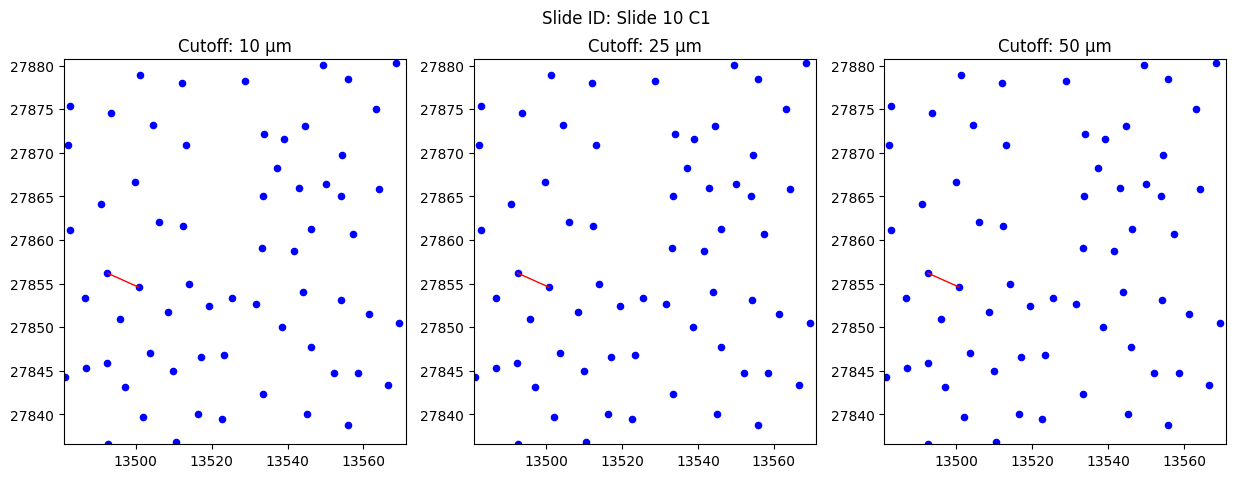

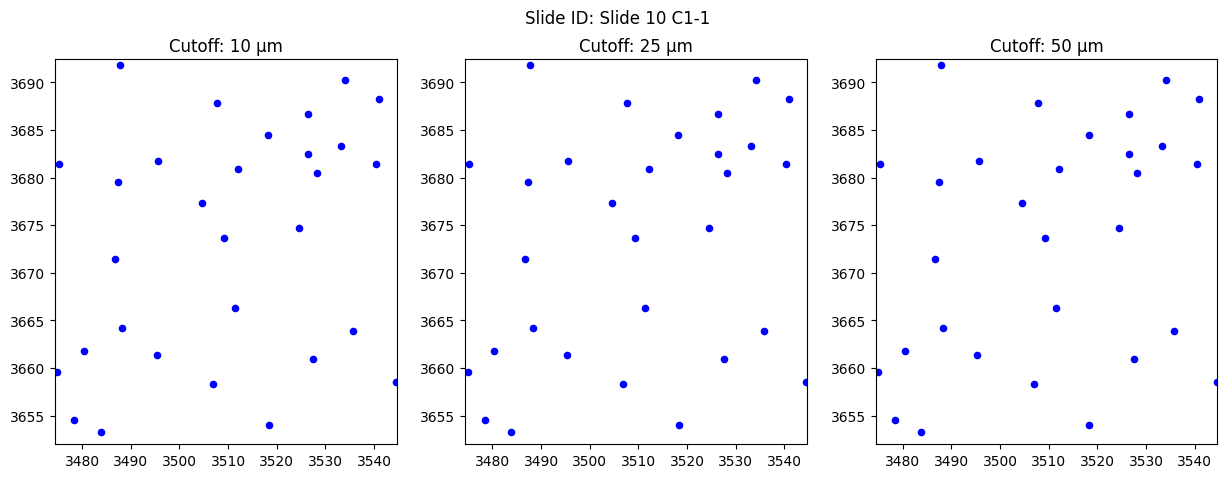

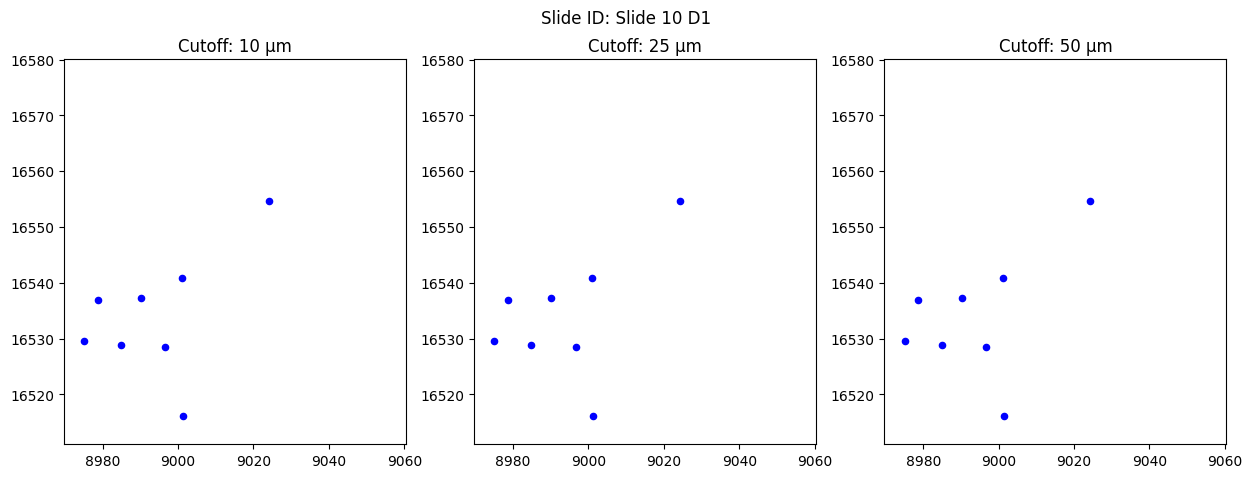

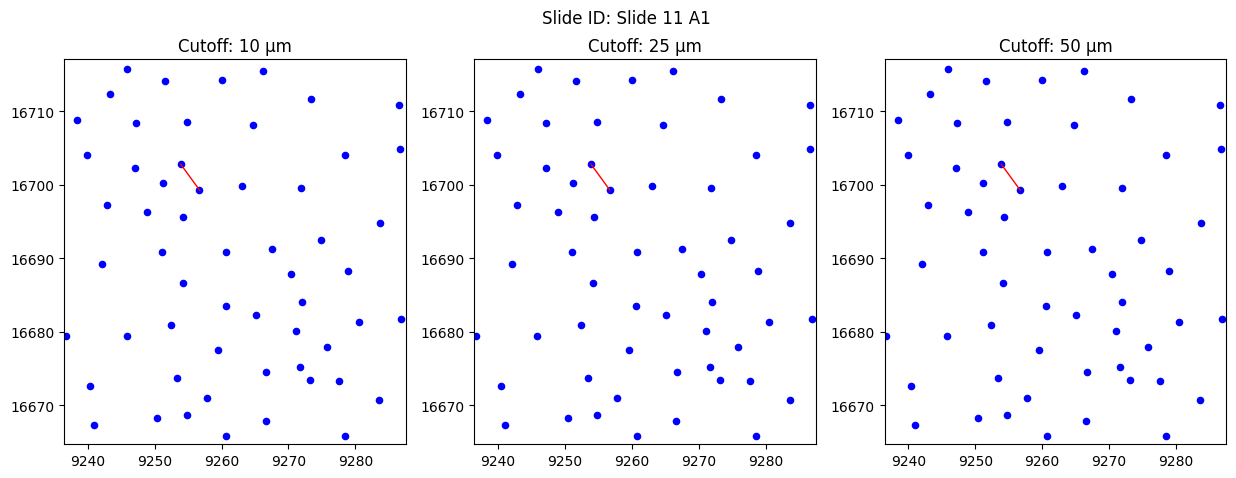

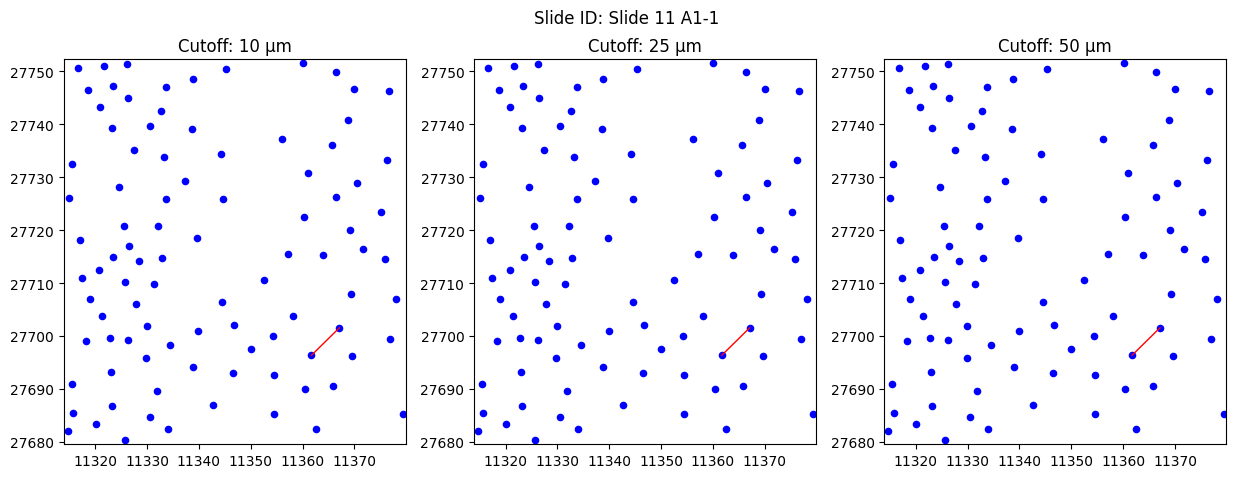

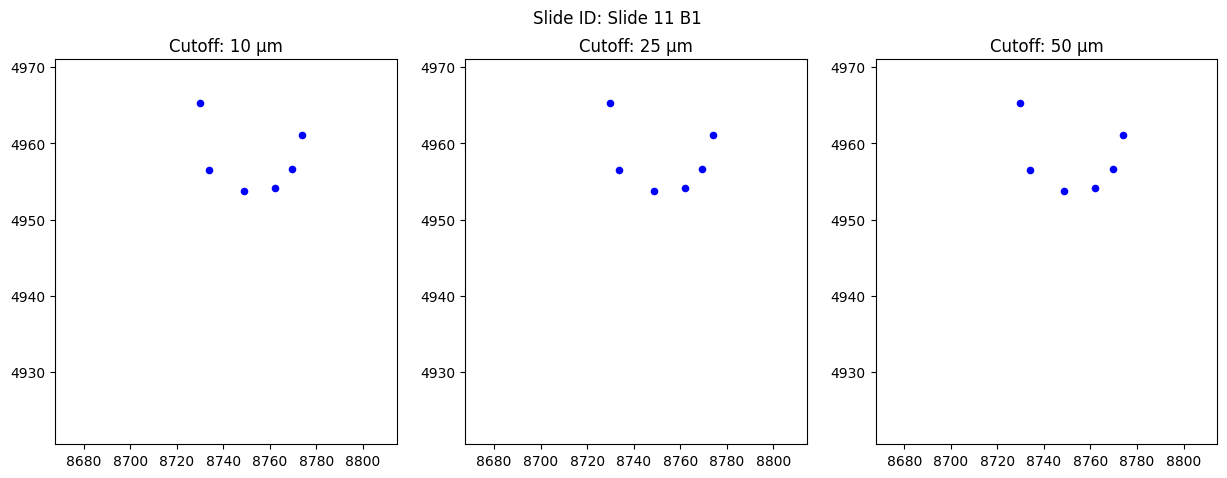

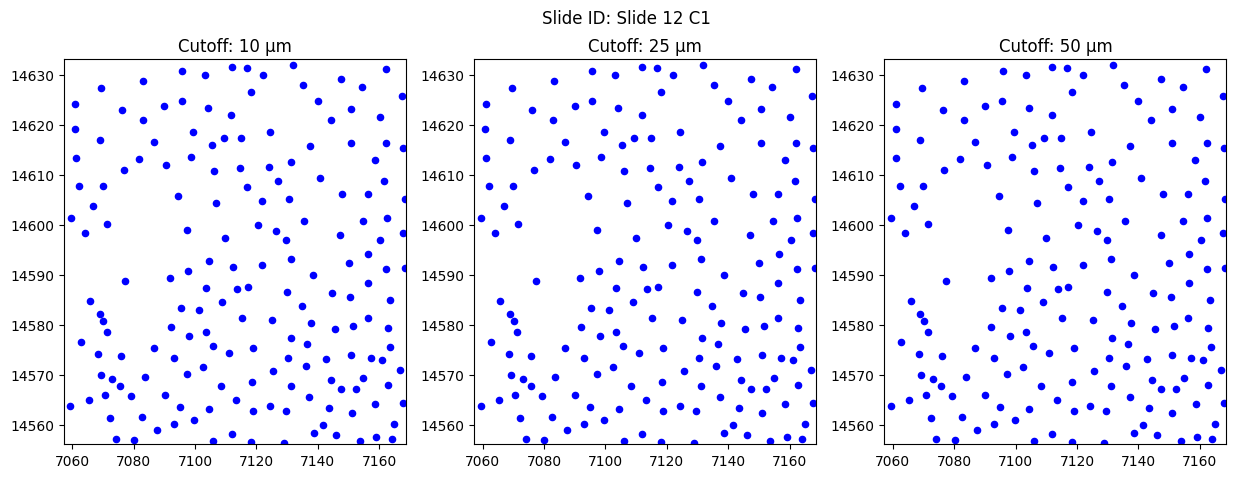

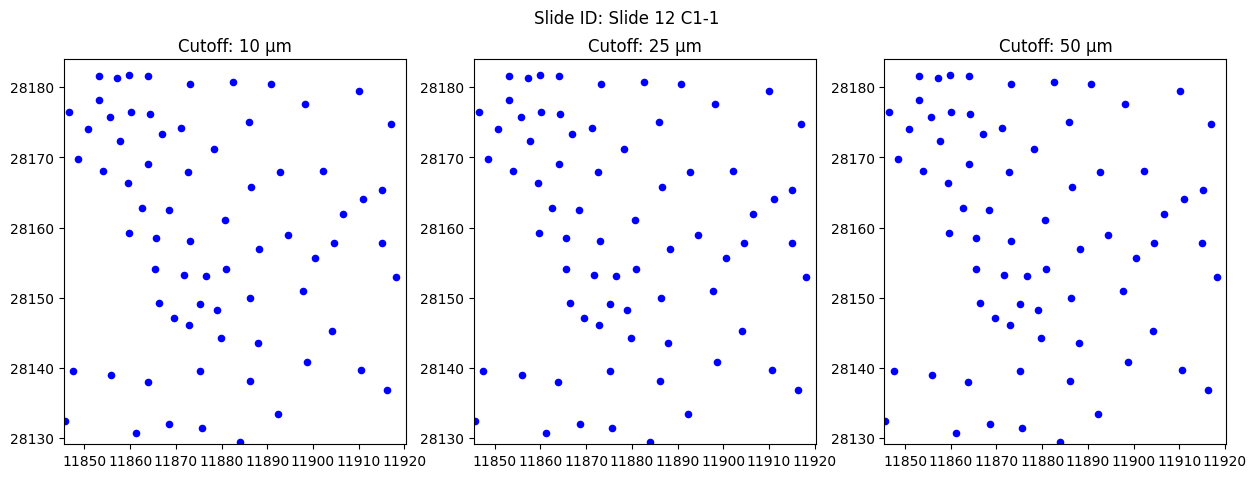

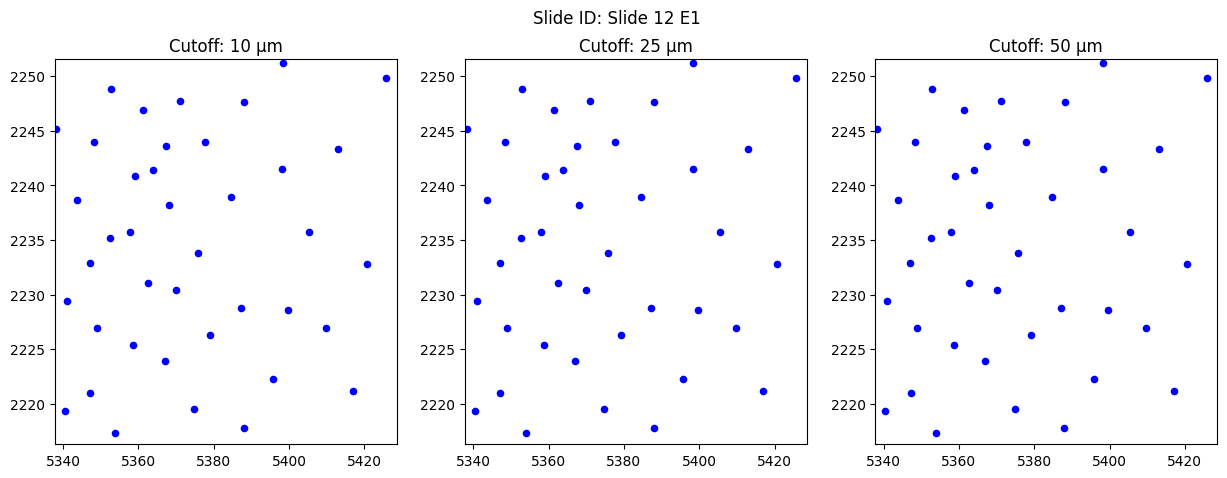

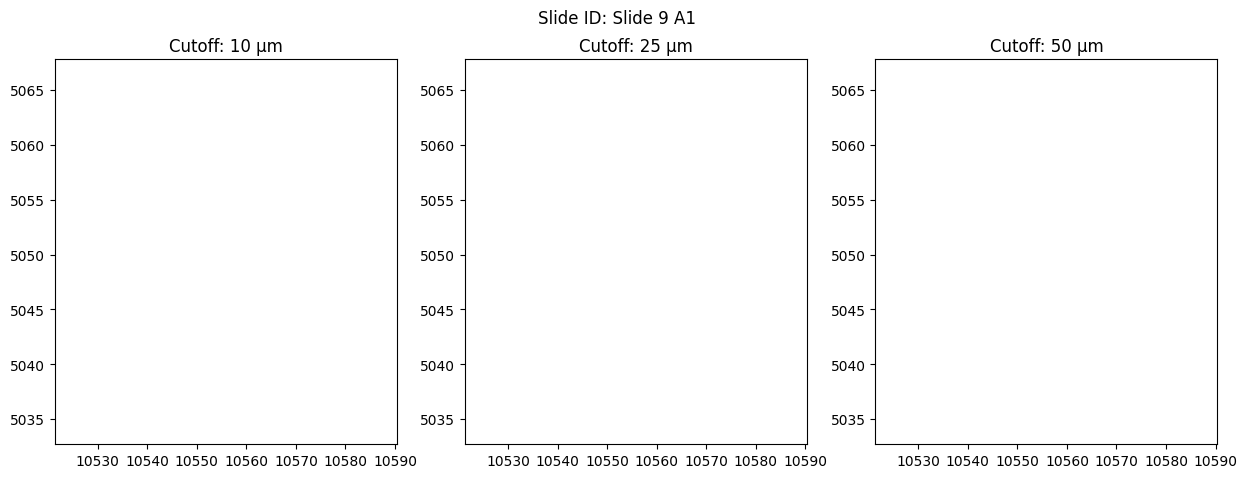

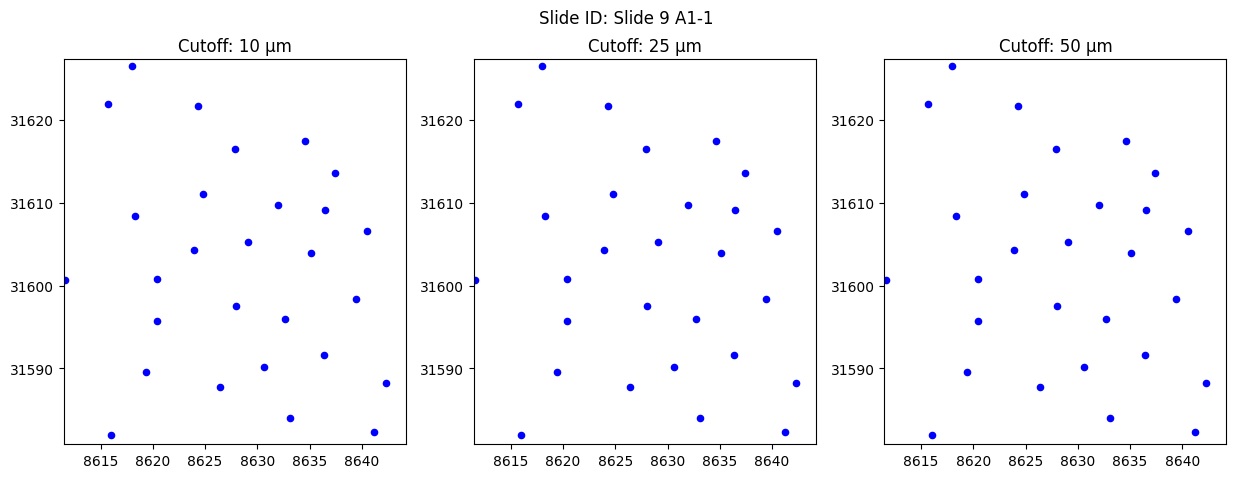

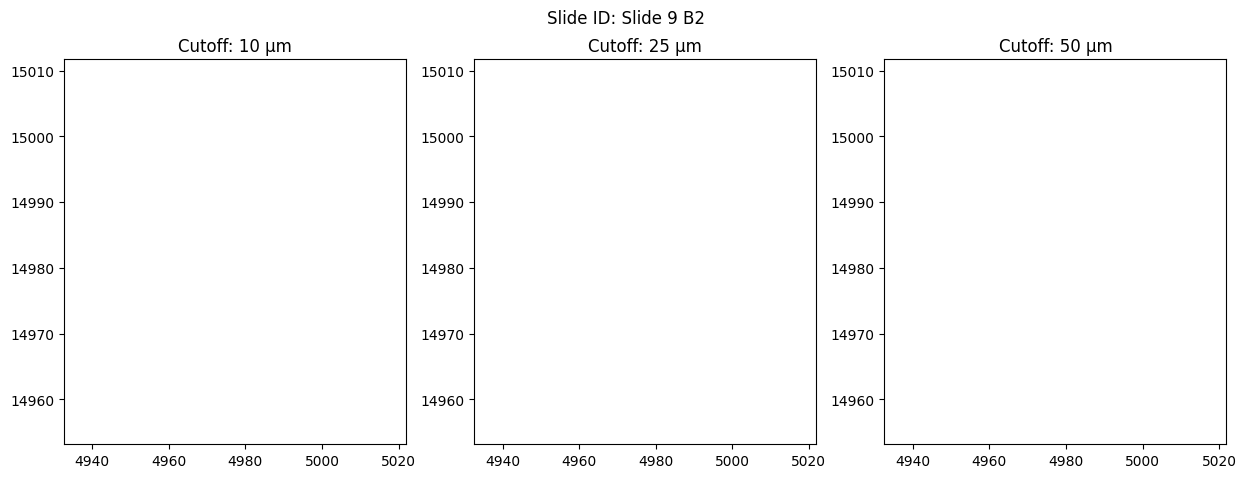

In [6]:
distance_cutoffs = [10, 25, 50]
phenotypes_interest = ['Mem Helper T', 'Inhib Monocyte', 'Th1 Helper T', 'Act Macrophage', 'Ant Pres Monocyte', 'Inhib Monocyte', 
 'Ant Pres Dendritic', 'NK Cell', 'Plasma B', 'B Cell']
analyze_slide(df, distance_cutoffs, phenotypes_interest)

In [7]:
def analyze_slide_unzoomed(df, distance_cutoffs, phenotypes_oi):
    """ Analyze each slide, perform triangulation, filter edges for each cutoff, and plot. """
    grouped = df.groupby('Parent')
    
    for name, group in grouped:
        coords = group[['Centroid X µm', 'Centroid Y µm']].values
        phenotypes = group['Phenotype'].values

        phenotype_mask = np.array([phenotype in phenotypes_oi for phenotype in phenotypes])
        
        # Delaunay triangulation
        tri = Delaunay(coords)
        
        # plot for each distance cutoff
        num_cutoffs = len(distance_cutoffs)
        fig, axs = plt.subplots(1, num_cutoffs, figsize=(15, 5))
        if num_cutoffs == 1:
            axs = [axs]
        
        for i, cutoff in enumerate(distance_cutoffs):
            filtered_edges = filter_edges(tri, cutoff, phenotype_mask) # get filtered graph
            plot_filtered_triangulation(axs[i], coords, filtered_edges, f'Cutoff: {cutoff} µm')
        
        plt.suptitle(f'Slide ID: {name}')
        plt.show()


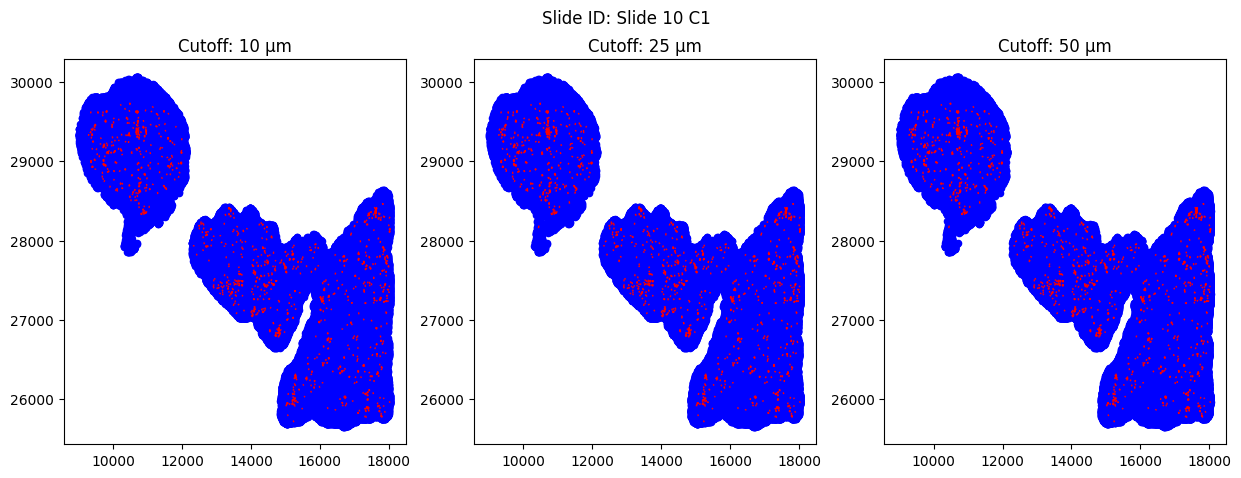

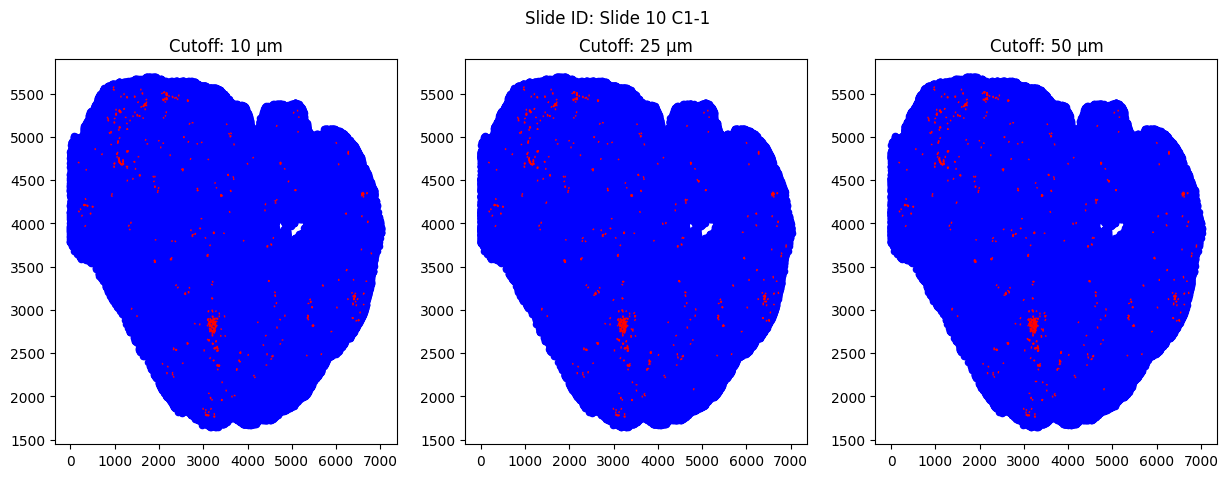

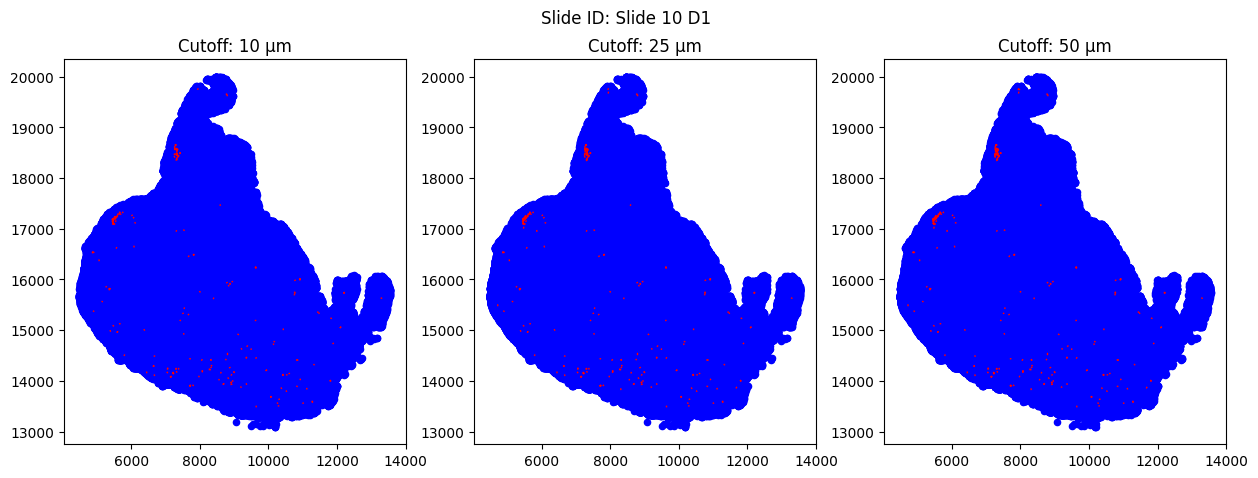

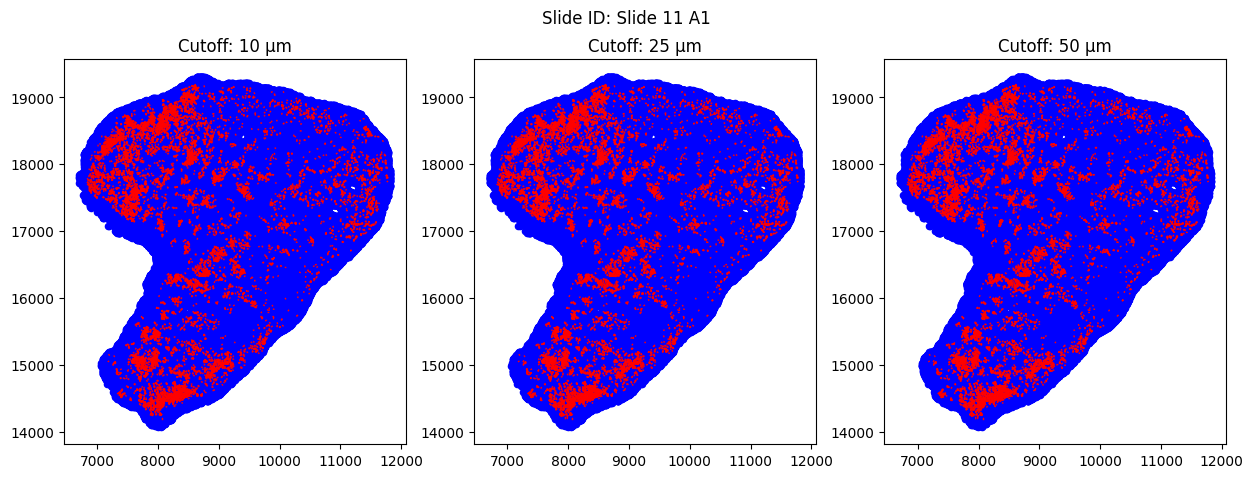

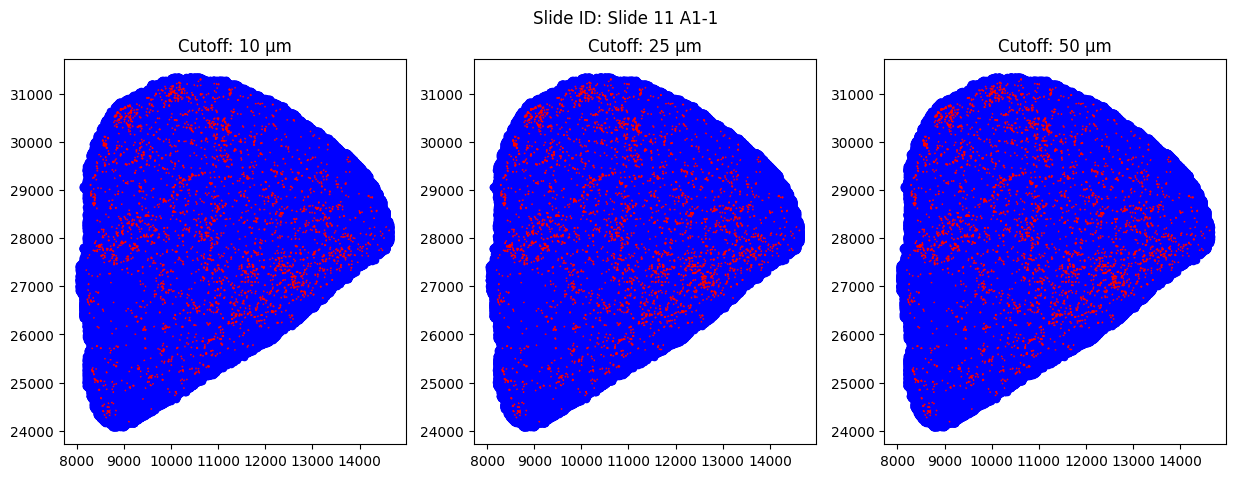

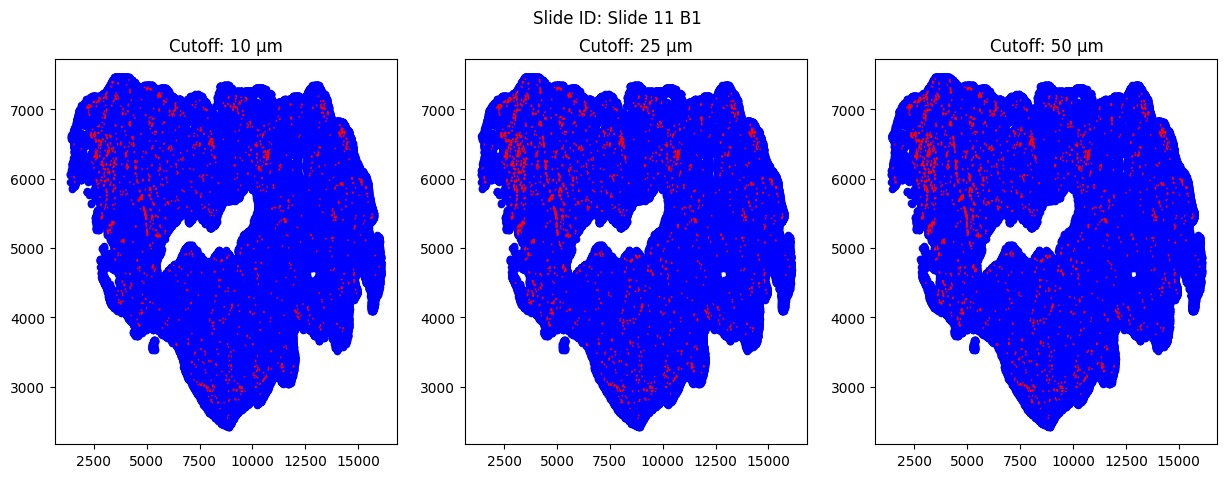

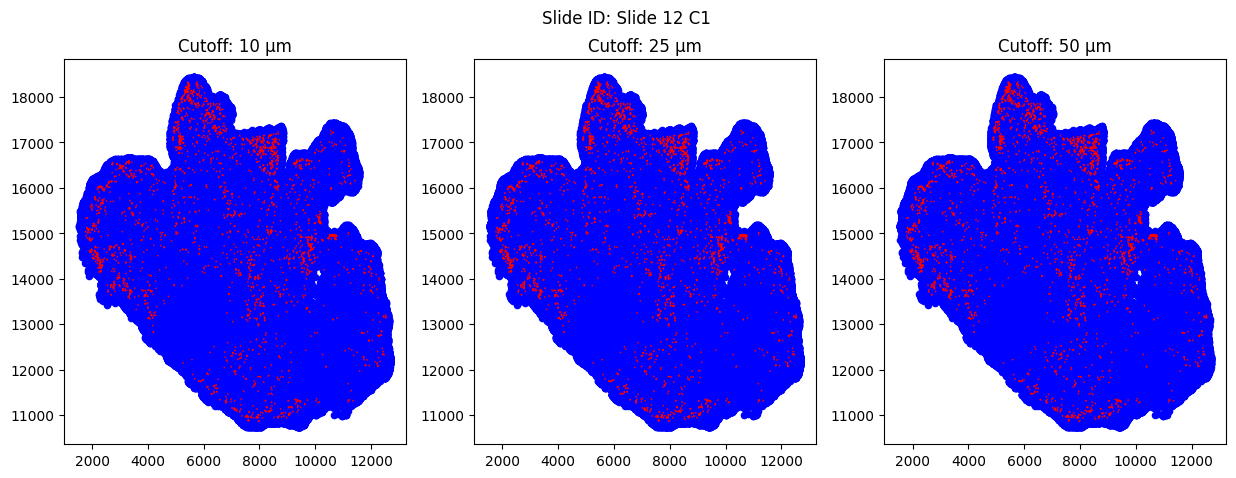

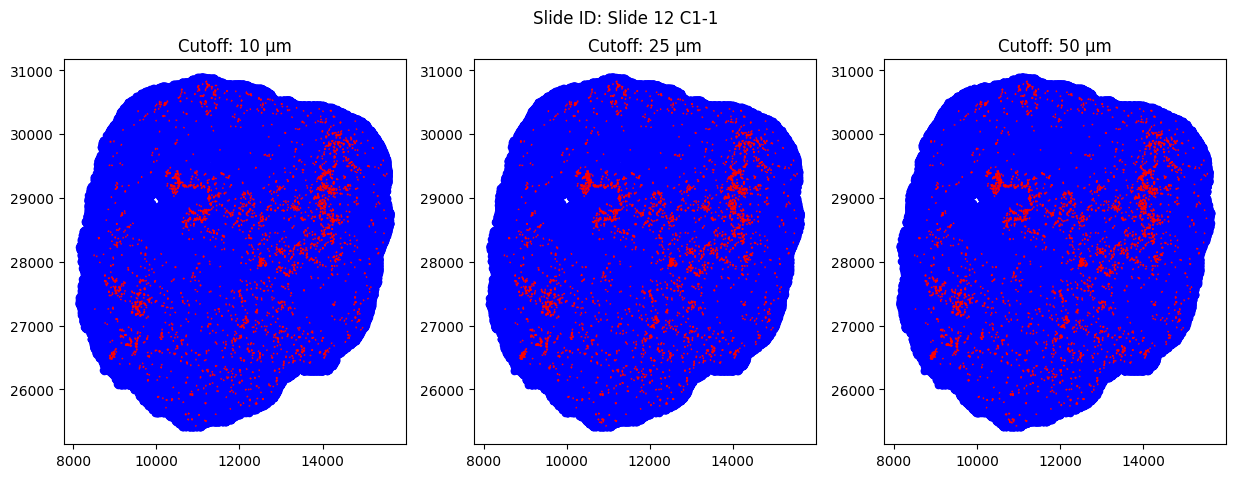

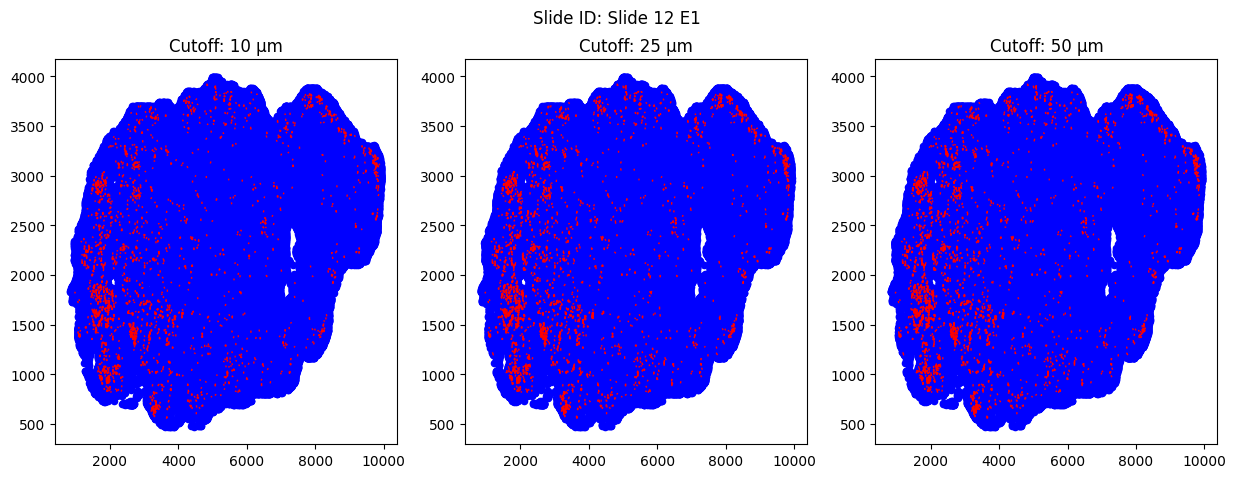

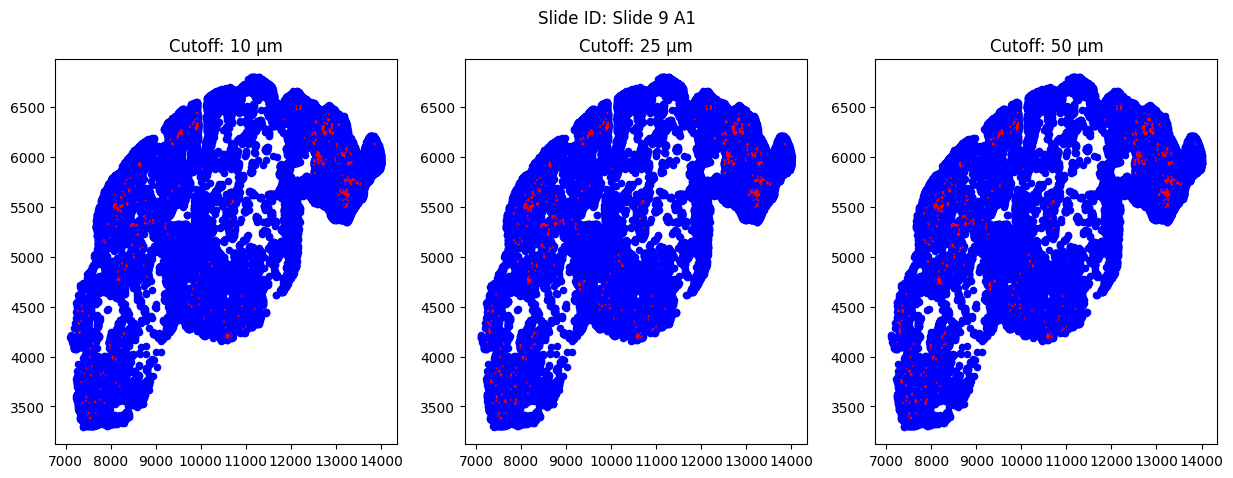

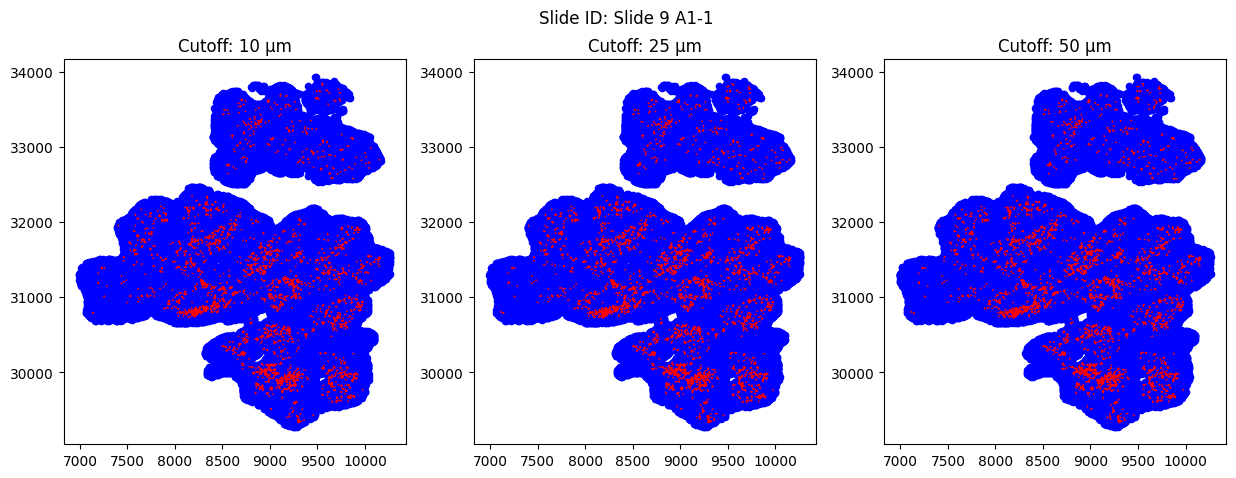

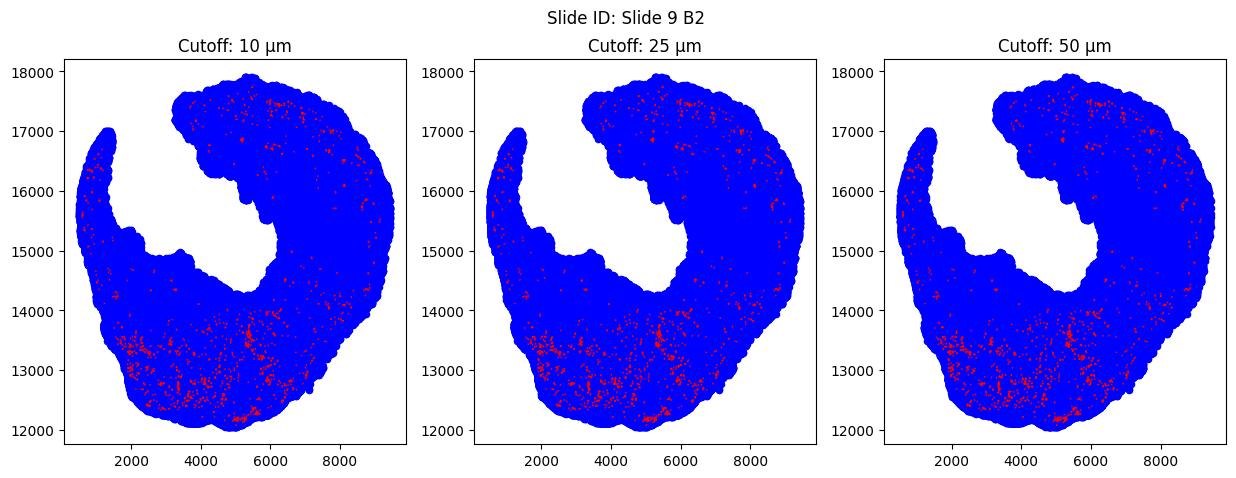

In [9]:
distance_cutoffs = [10, 25, 50]
phenotypes_interest = ['Mem Helper T', 'Inhib Monocyte', 'Th1 Helper T', 'Act Macrophage', 'Ant Pres Monocyte', 'Inhib Monocyte', 
 'Ant Pres Dendritic', 'NK Cell', 'Plasma B', 'B Cell']
analyze_slide_unzoomed(df, distance_cutoffs, phenotypes_interest)